In [1]:
import os, time
import numpy as np 
import corner as DFM
from astropy.io import fits
# --- gqp_mc ---
from gqp_mc import data as Data 
# --- provabgs --- 
from provabgs import infer as Infer
from provabgs import flux_calib as FluxCalib

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
specs, prop = Data.Spectra(sim='lgal', noise='bgs0', lib='bc03', sample='mini_mocha') 
photo, _ = Data.Photometry(sim='lgal', noise='legacy', sample='mini_mocha')

In [4]:
igal = 2

In [5]:
# set up prior object
priors = Infer.load_priors([
        Infer.UniformPrior(8, 12, label='sed'),     # uniform priors on logM*
        Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
        Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])


In [6]:
desi_mcmc = Infer.desiMCMC(
        prior=priors, 
        flux_calib=FluxCalib.no_flux_factor # no flux calibration necessary
        )

In [7]:
print('--- run mcmc ---') 
mcmc = desi_mcmc.run(
        wave_obs=specs['wave'], 
        flux_obs=specs['flux'][igal], 
        flux_ivar_obs=specs['ivar'][igal], 
        resolution=[specs['res_b'][igal], specs['res_r'][igal], specs['res_z'][igal]], 
        vdisp=150., 
        zred=prop['redshift'][igal], 
        mask='emline', 
        sampler='zeus',
        nwalkers=30, 
        burnin=1000,
        opt_maxiter=10000,
        niter=10000, 
        writeout=os.path.join(os.environ['GQPMC_DIR'], 'provabgs.convergence.hdf5'), 
        overwrite=True,
        debug=True)

--- run mcmc ---
--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/1000 [00:00<?, ?it/s]

initial theta = [10.309134392643015, 0.9249673522344737, 0.5830141440098343, 0.7492565012521606, 0.35908880626106354, 0.0017179724433129943, 0.0019156372789072798, 1.4685051564304352, 0.3230906992173547, -0.8667383642671711]
--- burn-in ---


Sampling progress : 100%|██████████| 1000/1000 [05:25<00:00,  3.08it/s]
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/10000 [00:00<?, ?it/s]

--- running main MCMC ---


Sampling progress : 100%|██████████| 10000/10000 [53:13<00:00,  3.13it/s]


  writing to ... /global/cscratch1/sd/chahah/gqp_mc/provabgs.convergence.hdf5
Speculator.sed: redshift = 0.309752
Speculator.sed: tage = 10.179948
Speculator.sed: theta [ 1.03128403e+01  1.64591723e-01  3.79186185e-01  7.79314459e-02
  3.78290646e-01  1.24011803e-03  1.52864551e-03  1.33487081e+00
  3.28558092e-01 -8.01888080e-01  1.01799475e+01]


In [11]:
mcmc = desi_mcmc.read_chain(os.path.join(os.environ['GQPMC_DIR'], 'provabgs.convergence.hdf5'))

In [13]:
mcmc['mcmc_chain'].shape

(10000, 30, 10)

In [15]:
flat_chain = desi_mcmc._flatten_chain(mcmc['mcmc_chain'])

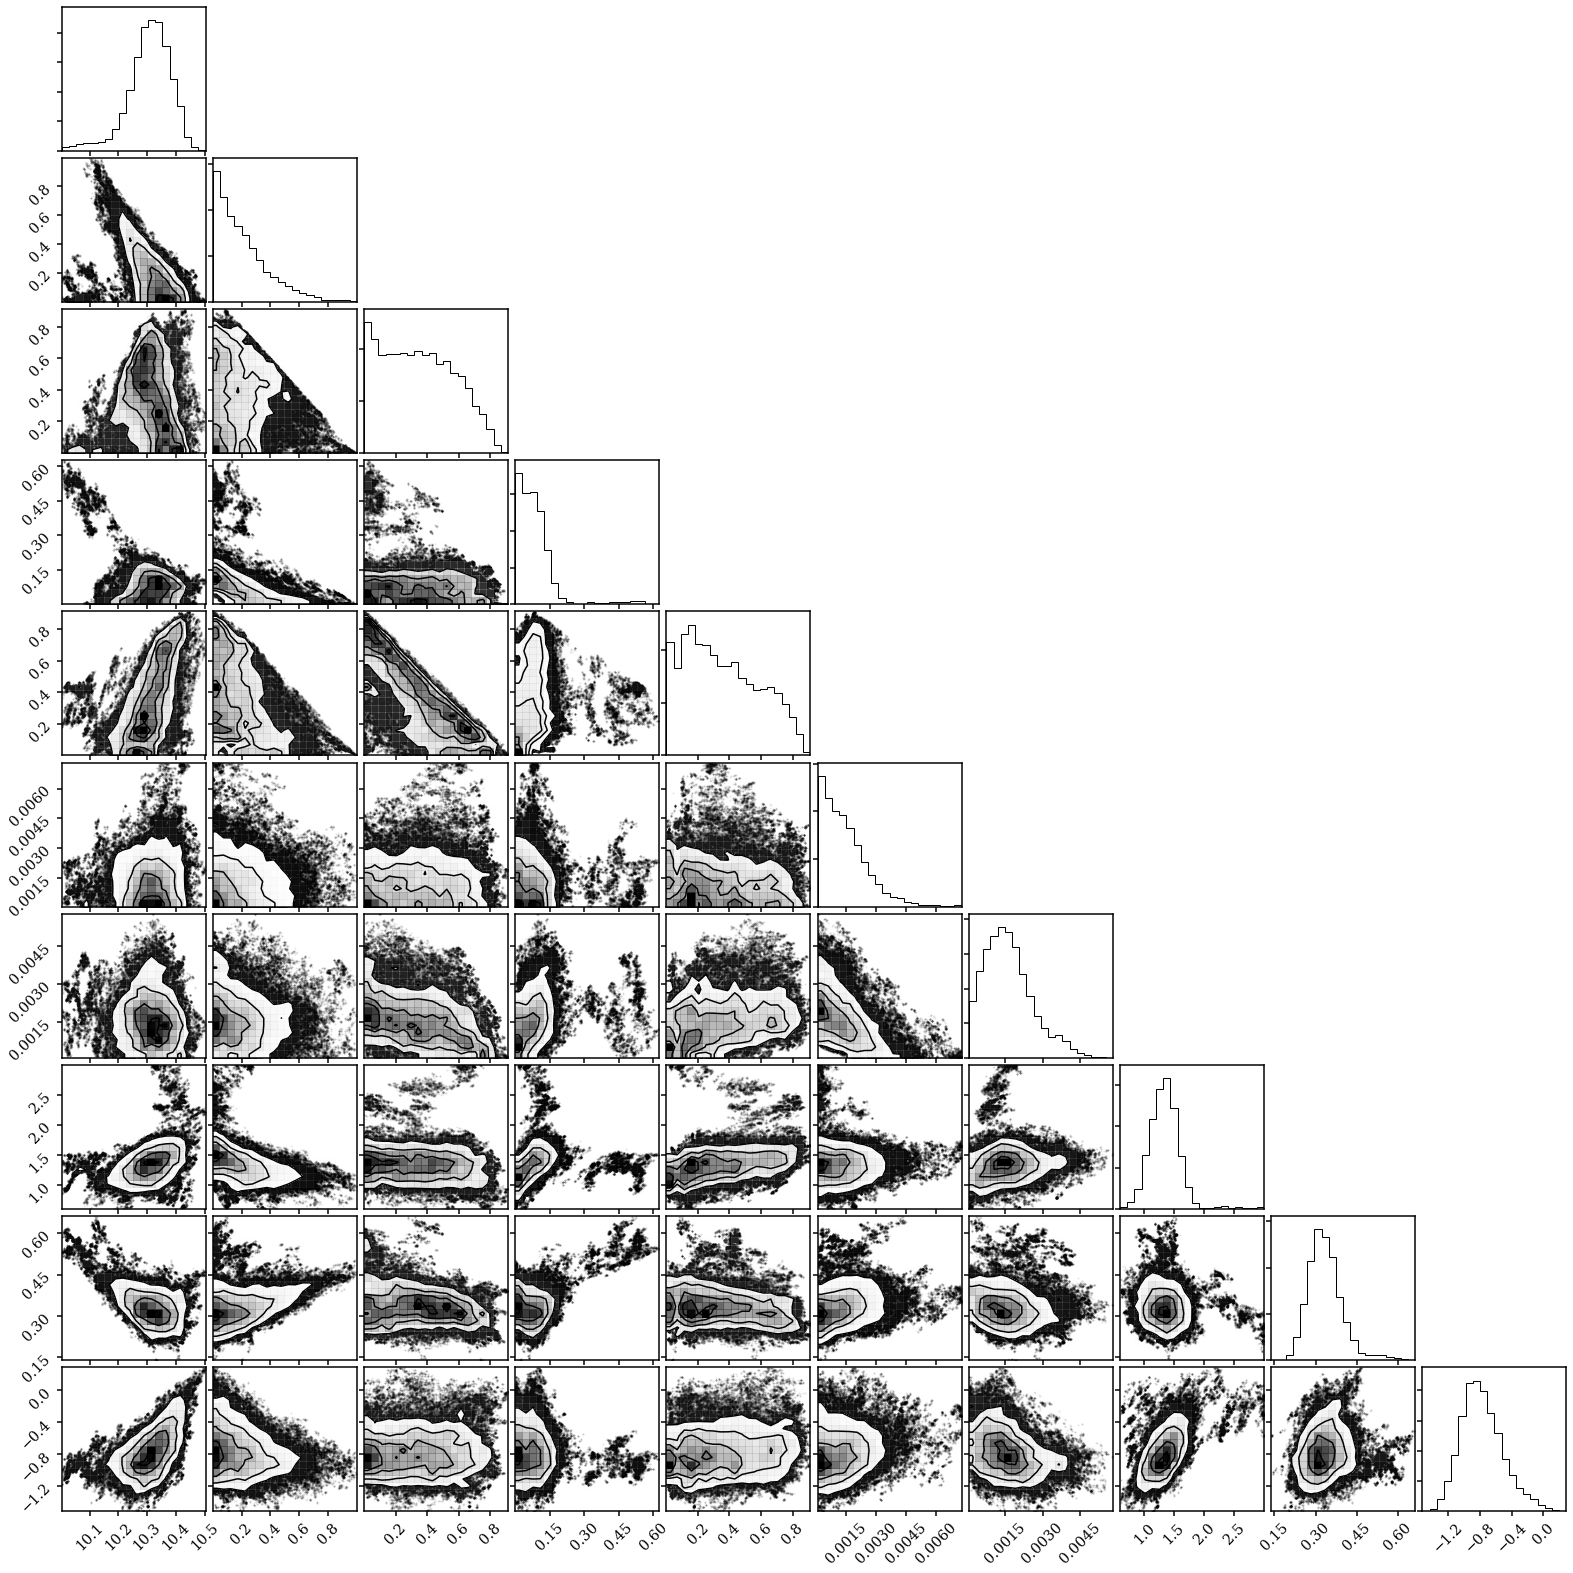

In [17]:
_ = DFM.corner(flat_chain)

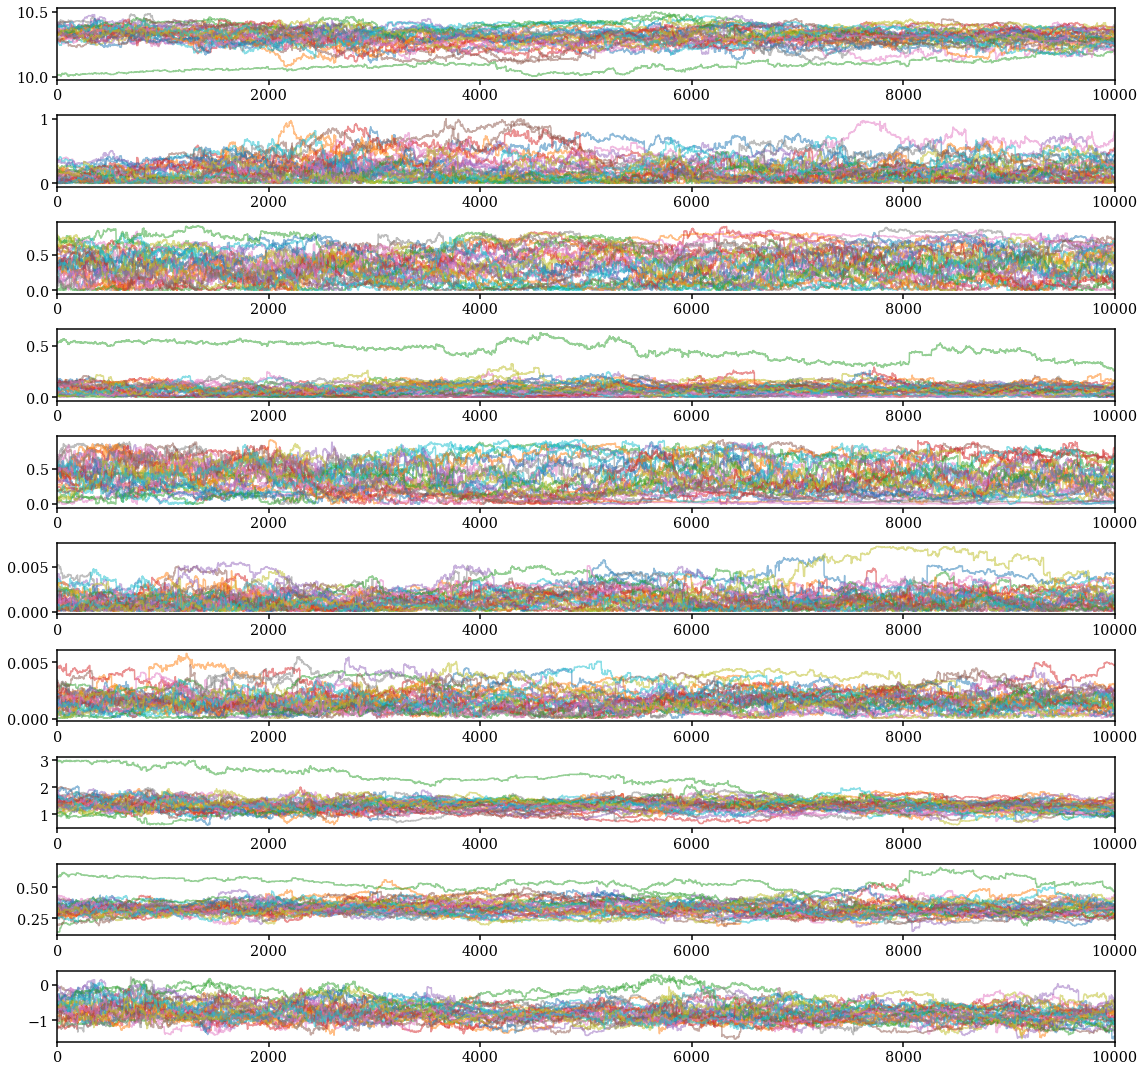

In [19]:
ndim = flat_chain.shape[1]
fig = plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    sub = fig.add_subplot(ndim,1,n+1)
    sub.plot(mcmc['mcmc_chain'][:,:,n], alpha=0.5)
    sub.set_xlim(0, 10000)
fig.tight_layout()
plt.show()

In [23]:
DFM.corner?

Signature:
DFM.corner(
    xs,
    bins=20,
    range=None,
    weights=None,
    color='k',
    smooth=None,
    smooth1d=None,
    labels=None,
    label_kwargs=None,
    show_titles=False,
    title_fmt='.2f',
    title_kwargs=None,
    truths=None,
    truth_color='#4682b4',
    scale_hist=False,
    quantiles=None,
    verbose=False,
    fig=None,
    max_n_ticks=5,
    top_ticks=False,
    use_math_text=False,
    hist_kwargs=None,
    **hist2d_kwargs,
)
Docstring:
Make a *sick* corner plot showing the projections of a data set in a
multi-dimensional space. kwargs are passed to hist2d() or used for
`matplotlib` styling.

Parameters
----------
xs : array_like[nsamples, ndim]
    The samples. This should be a 1- or 2-dimensional array. For a 1-D
    array this results in a simple histogram. For a 2-D array, the zeroth
    axis is the list of samples and the next axis are the dimensions of
    the space.

bins : int or array_like[ndim,]
    The number of bins to use in histograms, e

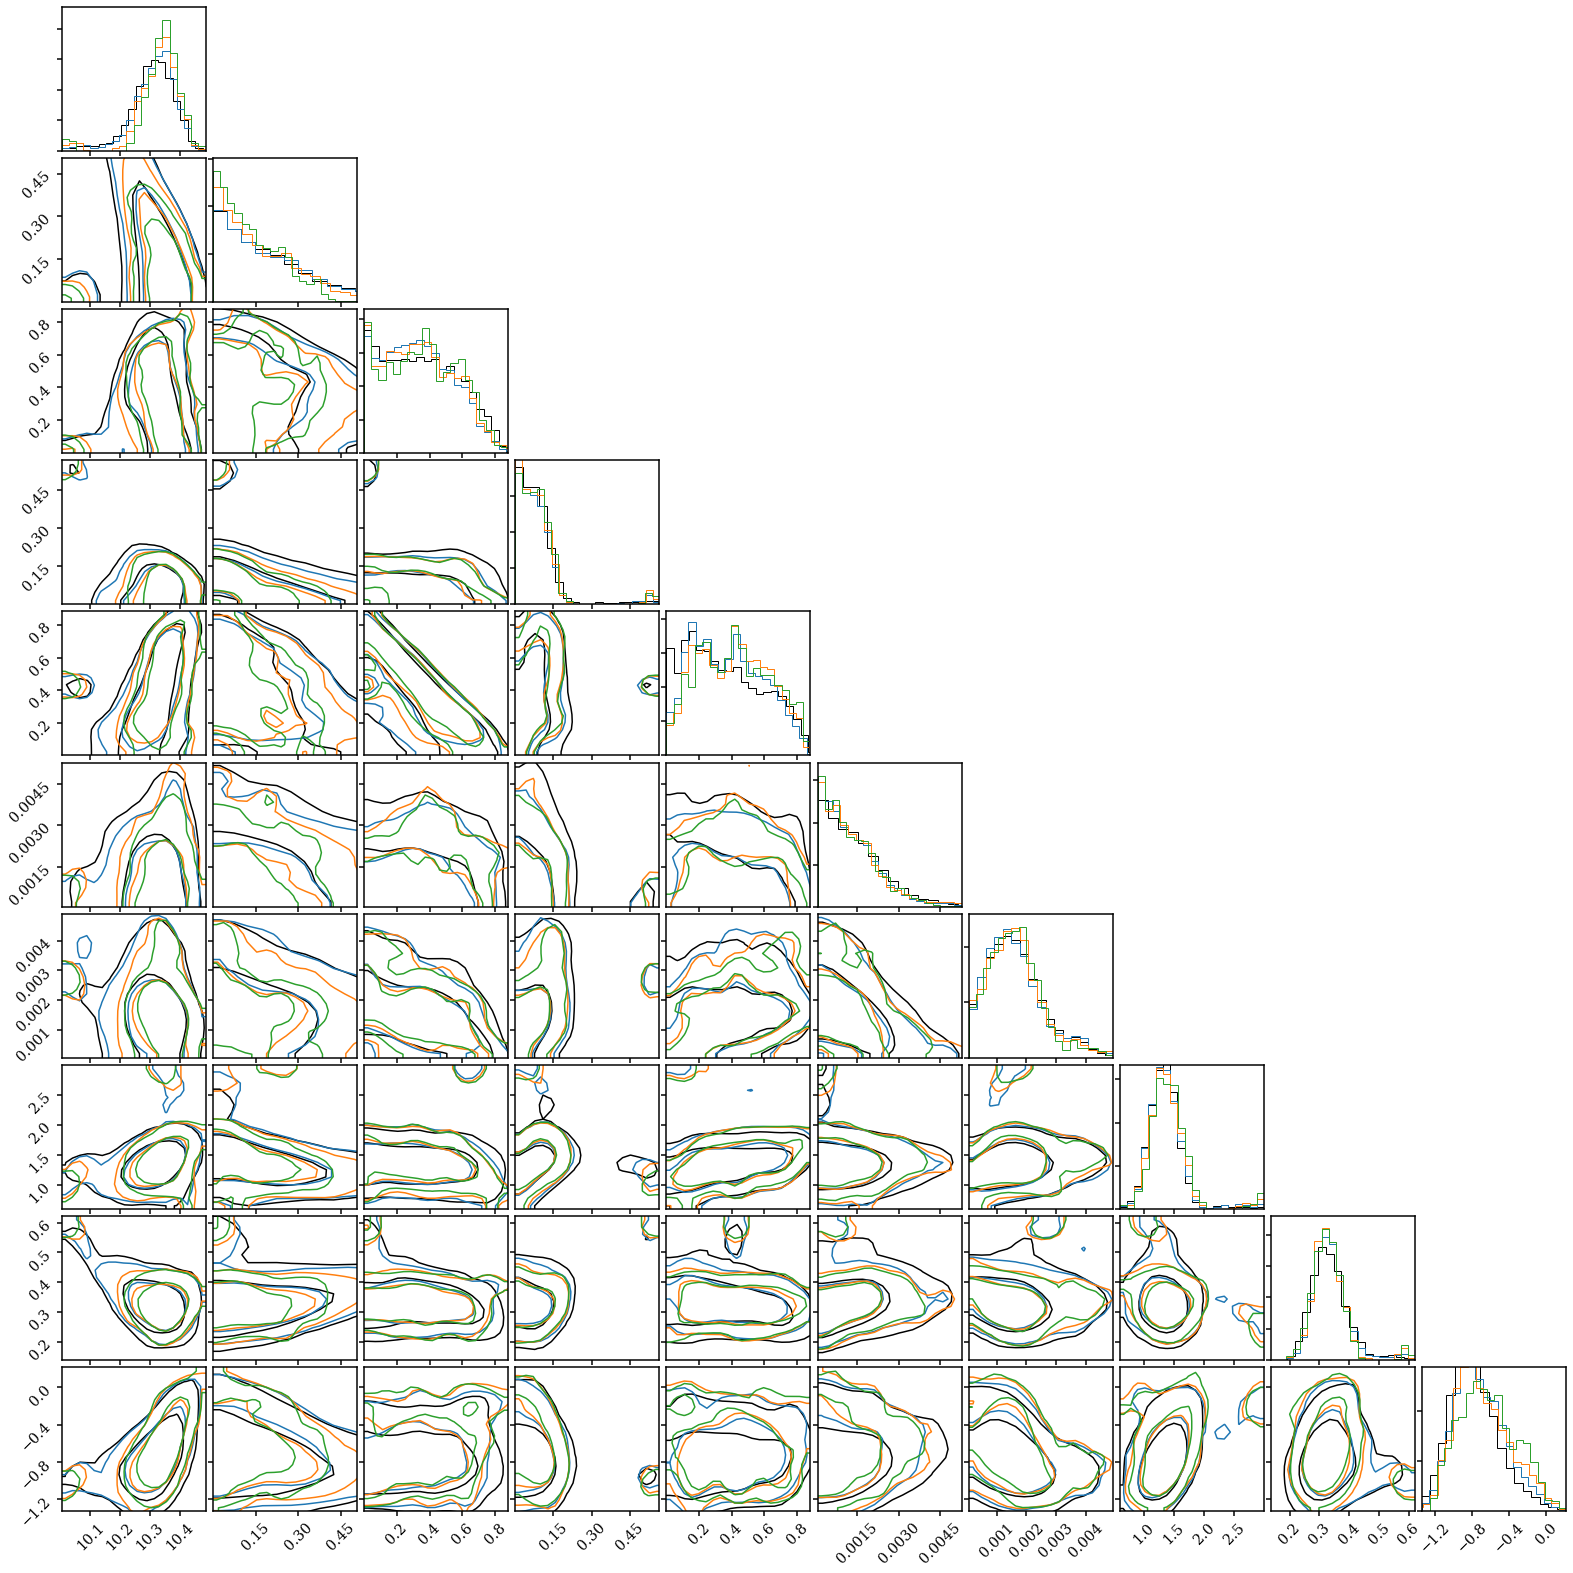

In [32]:
fig = DFM.corner(flat_chain, levels=[0.68, 0.95], color='k', smooth=True, plot_datapoints=False, fill_contours=False, plot_density=False, hist_kwargs={'density': True})
_ = DFM.corner(desi_mcmc._flatten_chain(mcmc['mcmc_chain'][:4000]), levels=[0.68, 0.95], color='C0', smooth=True, plot_datapoints=False, fill_contours=False, plot_density=False, hist_kwargs={'density': True}, fig=fig)
_ = DFM.corner(desi_mcmc._flatten_chain(mcmc['mcmc_chain'][:2000]), levels=[0.68, 0.95], color='C1', smooth=True, plot_datapoints=False, fill_contours=False, plot_density=False, hist_kwargs={'density': True}, fig=fig)
_ = DFM.corner(desi_mcmc._flatten_chain(mcmc['mcmc_chain'][:1000]), levels=[0.68, 0.95], color='C2', smooth=True, plot_datapoints=False, fill_contours=False, plot_density=False, hist_kwargs={'density': True}, fig=fig)

Reasonable convergence even with 1000 iterations. 2000 to be sure. 